In [994]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.io.shapereader as shapereader
import xarray as xr
import pandas as pd
import metpy
from metpy.units import units
import metpy.calc as mpcalc
#from mpl_toolkits.basemap import cm
import sys # to get argv
import os
import warnings
warnings.filterwarnings('ignore')

In [995]:
def calc_landslide_lisk_index(swi, p1h):
    a = 1.0
    b = 2.0
    index = a + swi + b * p1h # 危険度
    return index

In [996]:
def calc_maxloc(var):
    lon = var.coords["LON"]
    lat = var.coords["LAT"]
    maxloc = var.argmax(dim=["LON","LAT"])
    lon_max = lon[maxloc["LON"].data]
    lat_max = lat[maxloc["LAT"].data]
    return lon_max, lat_max

In [997]:
def draw_snake_line(swi, p1h):
    # スネーク曲線の可視化
    #plt.plot(swi1, p1h1) # スネーク曲線
    fs = 18
    plt.rcParams["font.size"]   = fs
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1, 1, 1)
    plt.title("Snake Line")
    plt.ylabel("P1h (mm)")
    plt.xlabel("SWI (mm)")
    plt.grid(which='major',color='gray',linestyle='-')
    plt.plot(swi.isel(TIME=slice(6,13)), p1h.isel(TIME=slice(6,13)), color='blue',  marker='o', ms=10, lw=3) # スネーク曲線
    plt.plot(swi.isel(TIME=slice(0, 7)), p1h.isel(TIME=slice(0, 7)), color='black', marker='o', ms=10, lw=3) # スネーク曲線
    ax.set_xlim([0,250])
    ax.set_ylim([0,100])
#    ax.set_xlim([0,300])
#    ax.set_ylim([0,150])    

In [998]:
def draw_landslide_lisk_index(index):
#    index.plot()
    fs = 18
    plt.rcParams["font.size"]   = fs
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(1, 1, 1)    
    index.isel(TIME=slice(6,13)).plot.line(color='blue', marker='o', ms=10, lw=3) # FT = 0 ~ 6h
    index.isel(TIME=slice(0,7)).plot.line(color='black', marker='o', ms=10, lw=3) # 0: FT=-6h, 6:FT=0h, 7: FT=1h, 12: FT=6h
    #ind.isel(TIME=slice(6,13)).plot.line(color='blue') # FT = 0 ~ 6h
    #ind.isel(TIME=slice(6,13)).plot(marker='blue') # FT = 0 ~ 6h
    plt.grid(which='major',color='gray',linestyle='-')
#    plt.title("")
    plt.ylabel("Landslide lisk index (mm)")
    plt.xlabel("Time (MM-DD hh; UTC)")
#    ax.set_xlim([0,250])
    ax.set_ylim([0,400])

In [999]:
nc = '../data/4p-jmasnake/4p-jmasnake_snakekyushu_2022-07-18_1800utc.nc'
ds  = xr.open_dataset(nc)#.sel(LON=slice(xmin,xmax)).sel(LAT=slice(ymin,ymax))
swi = ds["SWI"]
p1h = ds["P60"]
#ind
#ind.isel(TIME=0).plot()

## (1) シングルメンバーのスネーク曲線（位置ズレなし）

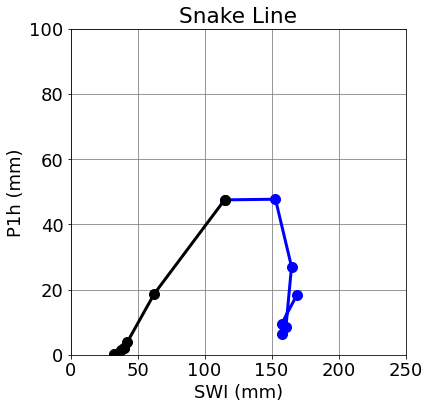

In [1000]:
# (1) シングルメンバーのスネーク曲線（位置ズレなし）
lon1 = 131.01
#lat1 = 33.36
lat1 = 33.32

#ind1.plot()
swi1 = swi.sel(LON=lon1, LAT=lat1, method="nearest")
p1h1 = p1h.sel(LON=lon1, LAT=lat1, method="nearest")
#swi1 = swi.sel(LON=lon1).sel(LAT=lat1) 
#p1h1 = p1h.sel(LON=lon1).sel(LAT=lat1) 
draw_snake_line(swi1, p1h1)

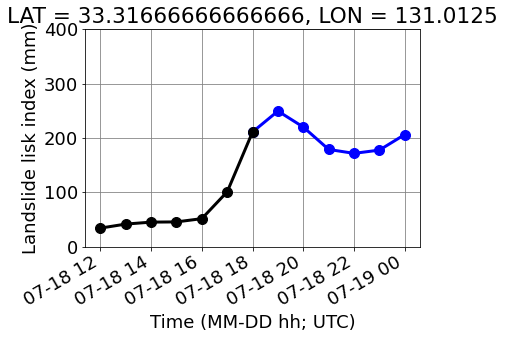

In [1001]:
# 危険度指標の計算
ind1 = calc_landslide_lisk_index(swi1, p1h1)
# 危険度指標の可視化
draw_landslide_lisk_index(ind1)

## (2) シングルメンバーのスネーク曲線（位置ズレあり）

In [1002]:
# (2) シングルメンバーのスネーク曲線（位置ズレあり）
dlon = 0.18; dlat = 0.125 # 位置ズレ許容の範囲(deg) = 15 x 15 grids
xmin = lon1 - dlon / 2.0; xmax = lon1 + dlon / 2.0
ymin = lat1 - dlat / 2.0; ymax = lat1 + dlat / 2.0

# 位置ズレ許容の範囲（緯度経度）に対して、変数を抽出
swi2 = swi.sel(LON=slice(xmin,xmax)).sel(LAT=slice(ymin,ymax)) 
p1h2 = p1h.sel(LON=slice(xmin,xmax)).sel(LAT=slice(ymin,ymax))
ind2 = calc_landslide_lisk_index(swi2, p1h2)

swi2_f = swi2.isel(TIME=slice(7,13)) # 予測部分の切り取り
p1h2_f = p1h2.isel(TIME=slice(7,13)) # 予測部分の切り取り
ind2_f = ind2.isel(TIME=slice(7,13)) # 予測部分の切り取り

ind2_f_tmax = ind2_f.max("TIME") # FT=1h~6h に対して時間最大をとる
#swi2

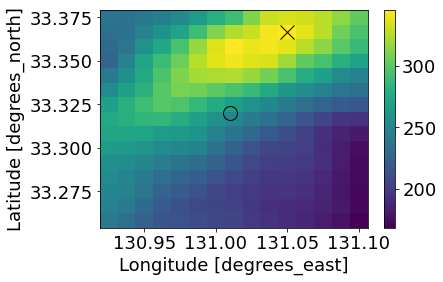

In [1003]:
# 土砂災害危険度指数の（時間）最大値が最大となる地点(x)の緯度経度を抽出
lon_max2, lat_max2 = calc_maxloc(ind2_f_tmax)
#print(lon_max2, lat_max2)

# （可視化）
# 土砂災害危険度指数の（時間）最大値を描く
ind2_f_tmax.plot()
# 指定した地点（土壌雨量指数の下絵に対してクリックした地点）をoでプロット
plt.plot(lon1, lat1, marker='o', color='black', markersize=14, fillstyle='none', mew=1) 
# 土砂災害危険度指数が最大の地点をxでプロット
plt.plot(lon_max2, lat_max2, marker='x', color='black', markersize=14, fillstyle='none', mew=1) 

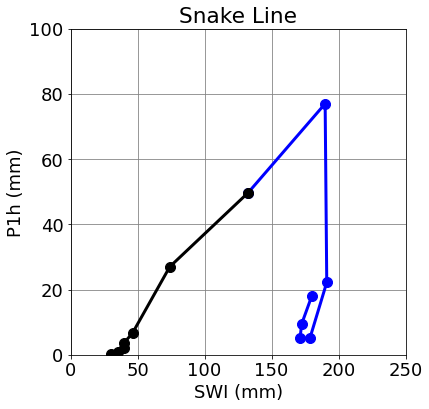

In [1004]:
# スネーク曲線を描くための土壌雨量指数と1時間積算雨量の抽出(xの位置)
swi2_max = swi2.sel(LON=lon_max2, LAT=lat_max2, method="nearest") # x の位置の土壌雨量
p1h2_max = p1h2.sel(LON=lon_max2, LAT=lat_max2, method="nearest") # x の位置の1時間積算雨量
draw_snake_line(swi2_max, p1h2_max) # スネーク曲線の描画

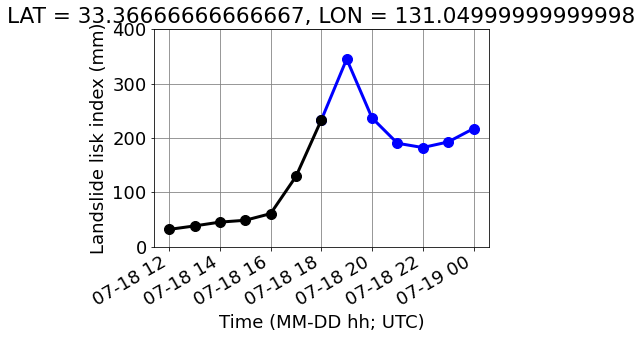

In [1005]:
# 危険度指標の計算
ind2_max = calc_landslide_lisk_index(swi2_max, p1h2_max)

# 危険度指標の可視化
draw_landslide_lisk_index(ind2_max)

## (3)アンサンブルメンバーのスネーク曲線（位置ズレなし）

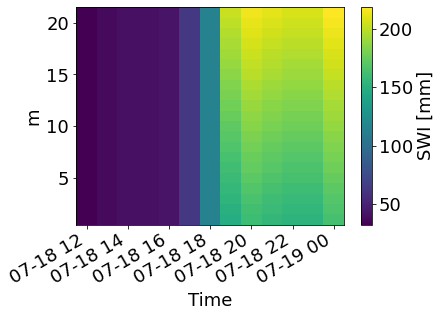

In [1006]:
#(3)アンサンブルメンバーのスネーク曲線（位置ズレなし）

nmax = 21 # アンサンブル数

swi3 = swi.sel(LON=lon1, LAT=lat1, method="nearest") # 
p1h3 = p1h.sel(LON=lon1, LAT=lat1, method="nearest")

def set_ensemble(nmax, da):
    times = da.TIME
    var0 = da.data
#    var = var0[np.newaxis]
    var = np.zeros([nmax, times.size])

    n_member = np.arange(1, nmax+1)
#    np.random.seed(seed=1)    
#    d = (np.random.rand(nmax)) * 50
    d = np.linspace(-5, 50, nmax)

    for i in range(nmax):
#        var0 = np.roll(var0, 1, axis=1) # 時間方向に1時間シフト
        var[i, 0:7]  = var0[0:7]
        var[i, 7:13] = var0[7:13] + d[i]
#        var = np.append(var, var1, axis=0)

    da_ou = xr.DataArray(var, coords=[n_member, times], dims=['m', 'TIME'])
    da_ou.name = da.name
    da_ou.attrs['units'] = da.attrs['units']
    return da_ou

# 疑似アンサンブルメンバーの作成 (SWIとP1hに21メンバーを追加) 
swi3_e = set_ensemble(nmax, swi3)
p1h3_e = set_ensemble(nmax, p1h3)
swi3_e.plot()
#p1h3_e.plot()

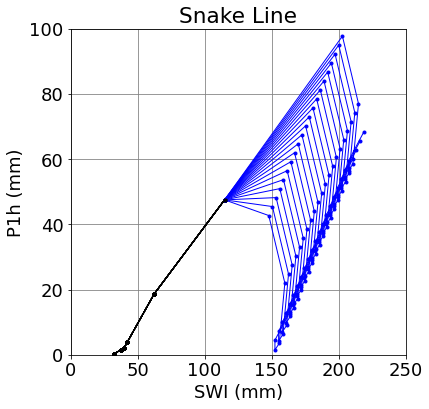

In [1007]:
def draw_snake_line_ens(swi, p1h, nmax):
    # スネーク曲線の可視化
    #plt.plot(swi1, p1h1) # スネーク曲線
    fs = 18
    plt.rcParams["font.size"]   = fs
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1, 1, 1)
    plt.title("Snake Line")
    plt.ylabel("P1h (mm)")
    plt.xlabel("SWI (mm)")
    plt.grid(which='major',color='gray',linestyle='-')
#    plt.plot(swi.isel(TIME=slice(6,13)), p1h.isel(TIME=slice(6,13)), color='blue',  marker='o', ms=10, lw=3) # スネーク曲線
#    plt.plot(swi.isel(TIME=slice(0, 7)), p1h.isel(TIME=slice(0, 7)), color='black', marker='o', ms=10, lw=3) # スネーク曲線

    for i in range(nmax):
#        print(i)
        x = swi.isel(m=i)
        y = p1h.isel(m=i)
        plt.plot(x.isel(TIME=slice(6,13)), y.isel(TIME=slice(6,13)), color='blue',  marker='o', ms=3, lw=1) # スネーク曲線
        plt.plot(x.isel(TIME=slice(0, 7)), y.isel(TIME=slice(0, 7)), color='black', marker='o', ms=3, lw=1) # スネーク曲線
         
    ax.set_xlim([0,250])
    ax.set_ylim([0,100])
#    ax.set_xlim([0,300])
#    ax.set_ylim([0,150])  


draw_snake_line_ens(swi3_e, p1h3_e, nmax)


In [1008]:
def draw_landslide_lisk_index_ens(index, nmax):
#    index.plot()
    fs = 18
    plt.rcParams["font.size"]   = fs
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(1, 1, 1)    
    for i in range(nmax):  
        index.isel(m=i).isel(TIME=slice(6,13)).plot.line(color='blue', marker='o', ms=2, lw=1) # FT = 0 ~ 6h
        index.isel(m=i).isel(TIME=slice(0,7)).plot.line(color='black', marker='o', ms=2, lw=1) # 0: FT=-6h, 6:FT=0h, 7: FT=1h, 12: FT=6h
    plt.grid(which='major',color='gray',linestyle='-')
#    plt.title("")
    plt.ylabel("Landslide lisk index (mm)")
    plt.xlabel("Time (MM-DD hh; UTC)")
#    ax.set_xlim([0,250])
    ax.set_ylim([0,400])

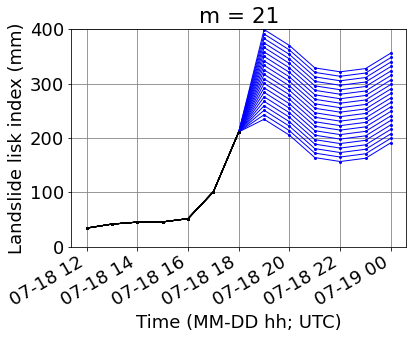

In [1009]:
# 危険度指標の計算
ind3 = calc_landslide_lisk_index(swi3_e, p1h3_e)

# 危険度指標の可視化
draw_landslide_lisk_index_ens(ind3, nmax)

In [1010]:
it_maxloc = ind3.argmax(dim="TIME") 
it_maxloc.data

array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])

In [1011]:
ind3_itmax = np.zeros(nmax)
for m in range(nmax): 
    it = it_maxloc[m]
    ind3_itmax[m] = ind3[m,it]
    
ind3_itmax

array([234.30001068, 242.55001068, 250.80001068, 259.05001068,
       267.30001068, 275.55001068, 283.80001068, 292.05001068,
       300.30000305, 308.55000305, 316.80000305, 325.05000305,
       333.30000305, 341.55000305, 349.80000305, 358.05000305,
       366.30000305, 374.55000305, 382.80000305, 391.05000305,
       399.30000305])

In [1012]:
n_member = np.arange(1, nmax+1)
x1 = pd.Series(ind3_itmax, index=n_member)
x2 = x1.sort_values(ascending=False)
x3 = x2.index
m_max = x3[0]          #アンサンブル最大のメンバー番号
m_med = x3[(nmax-1)/2] # アンサンブル中央のメンバー番号
m_min = x3[nmax-1]     # アンサンブル最小のメンバー番号

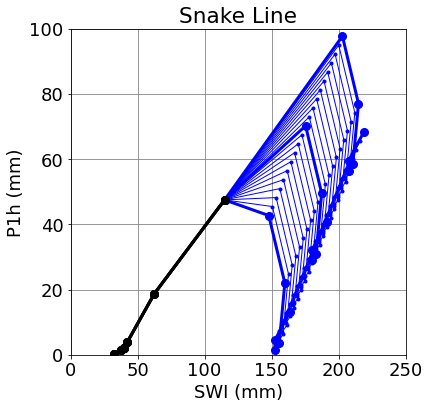

In [1013]:
def draw_snake_line_ens2(swi, p1h, nmax, m_max, m_med, m_min):
    # スネーク曲線の可視化
    #plt.plot(swi1, p1h1) # スネーク曲線
    fs = 18
    plt.rcParams["font.size"]   = fs
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1, 1, 1)
    plt.title("Snake Line")
    plt.ylabel("P1h (mm)")
    plt.xlabel("SWI (mm)")
    plt.grid(which='major',color='gray',linestyle='-')
#    plt.plot(swi.isel(TIME=slice(6,13)), p1h.isel(TIME=slice(6,13)), color='blue',  marker='o', ms=10, lw=3) # スネーク曲線
#    plt.plot(swi.isel(TIME=slice(0, 7)), p1h.isel(TIME=slice(0, 7)), color='black', marker='o', ms=10, lw=3) # スネーク曲線

    def draw_line(swi, p1h, i, ms, lw):
        x = swi.isel(m=i)
        y = p1h.isel(m=i)
        plt.plot(x.isel(TIME=slice(6,13)), y.isel(TIME=slice(6,13)), color='blue',  marker='o', ms=ms, lw=lw) # スネーク曲線
        plt.plot(x.isel(TIME=slice(0, 7)), y.isel(TIME=slice(0, 7)), color='black', marker='o', ms=ms, lw=lw) # スネーク曲線


    for i in range(nmax):
#        print(i)
        ms = 3; lw = 1
        draw_line(swi, p1h, i, ms, lw)

    ms = 8; lw = 3
    draw_line(swi, p1h, m_max-1, ms, lw)
    draw_line(swi, p1h, m_med-1, ms, lw)
    draw_line(swi, p1h, m_min-1, ms, lw)
        
    ax.set_xlim([0,250])
    ax.set_ylim([0,100])

draw_snake_line_ens2(swi3_e, p1h3_e, nmax, m_max, m_med, m_min)

## (4)アンサンブルメンバーのスネーク曲線（位置ズレあり）

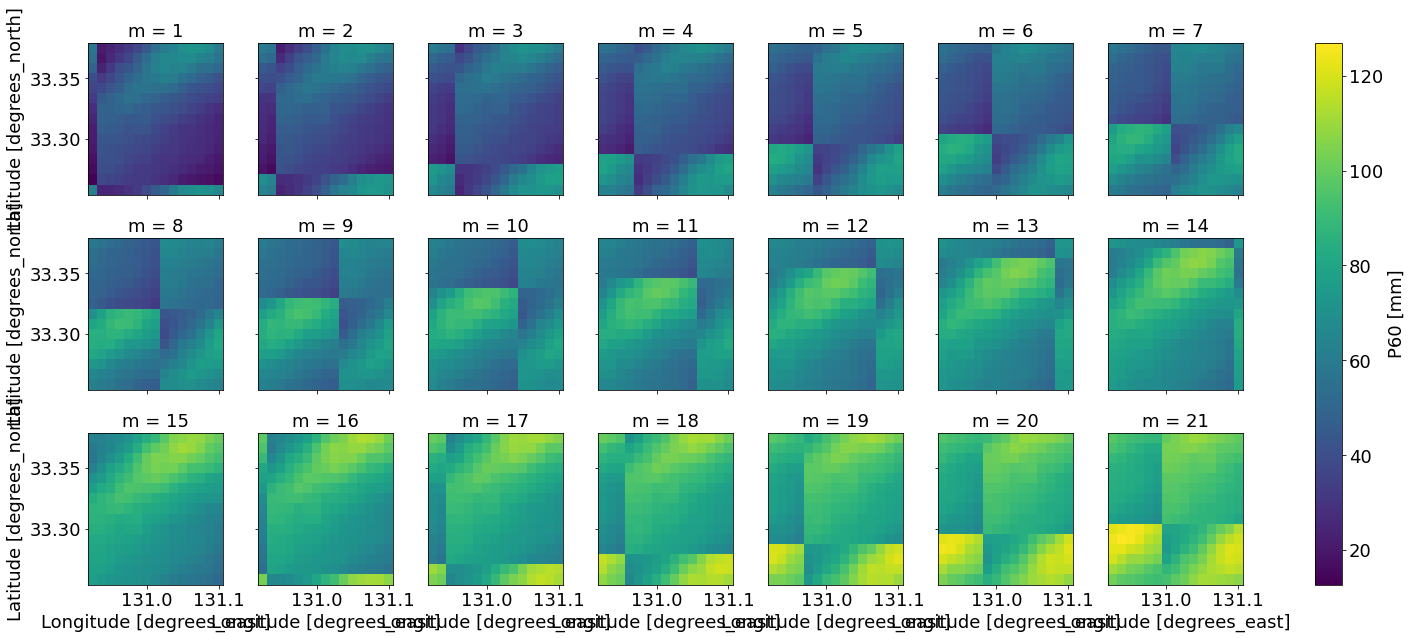

In [1014]:
dlon = 0.18; dlat = 0.125 # 位置ズレ許容の範囲(deg) = 15 x 15 grids
xmin = lon1 - dlon / 2.0; xmax = lon1 + dlon / 2.0
ymin = lat1 - dlat / 2.0; ymax = lat1 + dlat / 2.0

# 位置ズレ許容の範囲（緯度経度）に対して、変数を抽出
swi4 = swi.sel(LON=slice(xmin,xmax)).sel(LAT=slice(ymin,ymax)) 
p1h4 = p1h.sel(LON=slice(xmin,xmax)).sel(LAT=slice(ymin,ymax))

def set_ensemble(nmax, da):
    times = da.TIME
    lon = da.LON
    lat = da.LAT
    var0 = da.data
    var = np.zeros([nmax, times.size, lat.size, lon.size])

    n_member = np.arange(1, nmax+1)
#    np.random.seed(seed=1)    
#    d = (np.random.rand(nmax)) * 50
    d = np.linspace(-5, 50, nmax)

    for i in range(nmax):
        var0 = np.roll(var0, 1, axis=2) # 経度方向に-1グリッドシフト
        var0 = np.roll(var0, 1, axis=1) # 緯度方向に-1グリッドシフト
        
        var[i, 0:7 ,:,:]  = var0[0:7 , :, :]
        var[i, 7:13,:,:]  = var0[7:13, :, :] + d[i]
#        var = np.append(var, var1, axis=0)

    da_ou = xr.DataArray(var, coords=[n_member, times, lat, lon], dims=['m', 'TIME', 'LAT', 'LON'])
    da_ou.name = da.name
    da_ou.attrs['units'] = da.attrs['units']
    return da_ou


# 疑似アンサンブルメンバーの作成 (SWIとP1hに21メンバーを追加) 
swi4_e = set_ensemble(nmax, swi4)
p1h4_e = set_ensemble(nmax, p1h4)

swi4_e
#swi4_e.isel(TIME=7).plot(x="LON", y="LAT", col="m", col_wrap=7)
p1h4_e.isel(TIME=7).plot(x="LON", y="LAT", col="m", col_wrap=7)

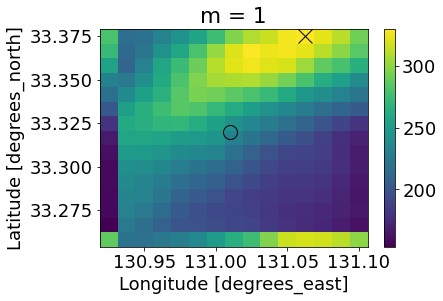

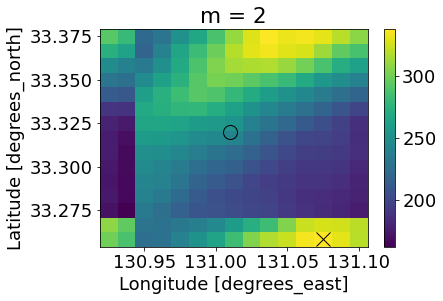

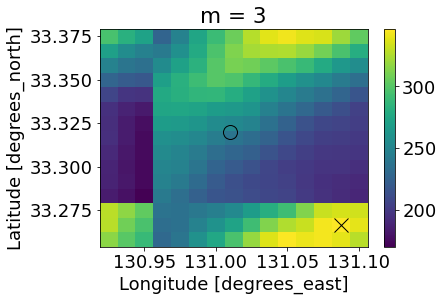

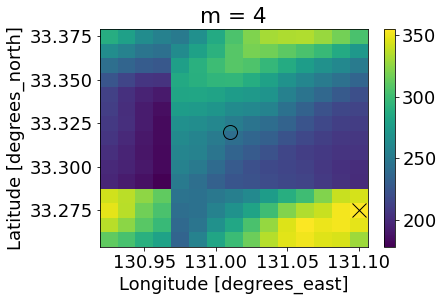

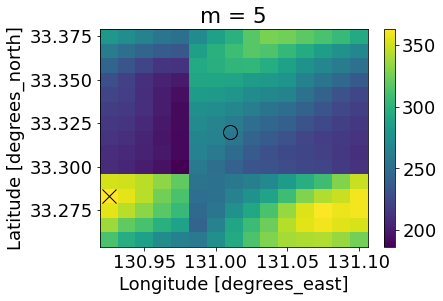

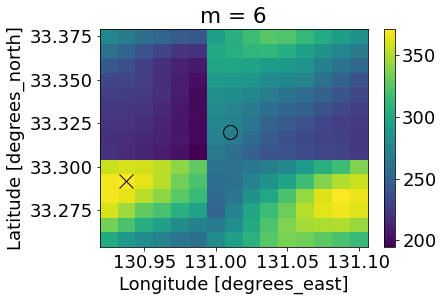

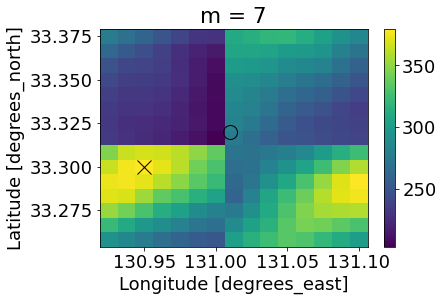

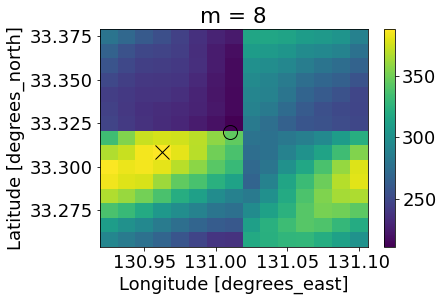

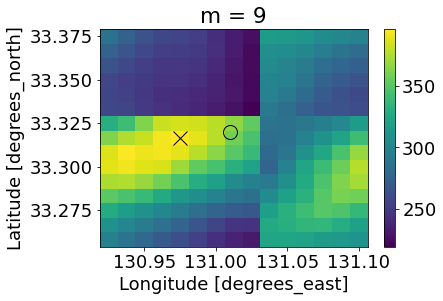

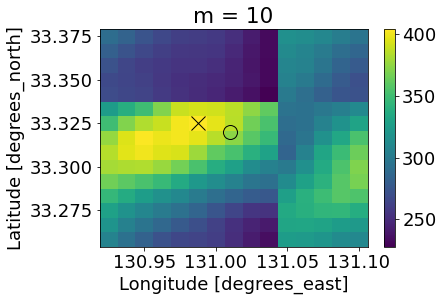

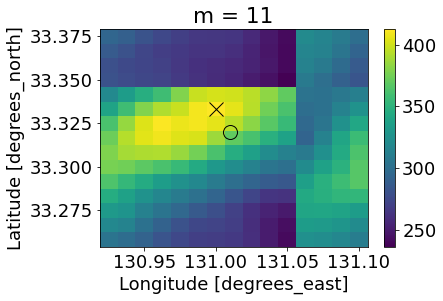

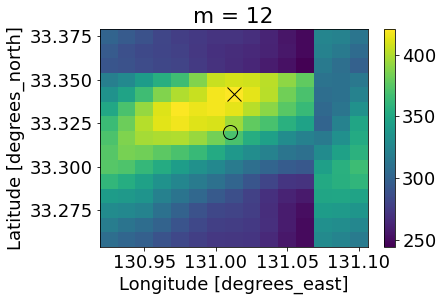

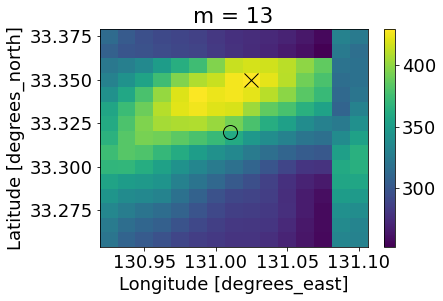

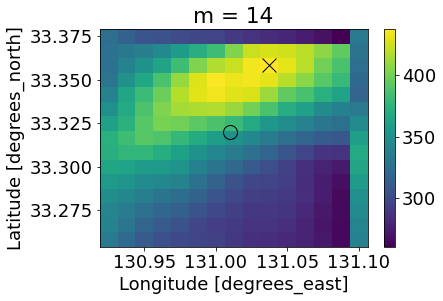

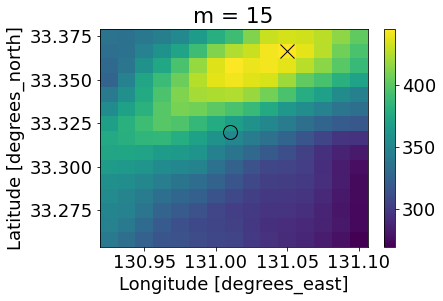

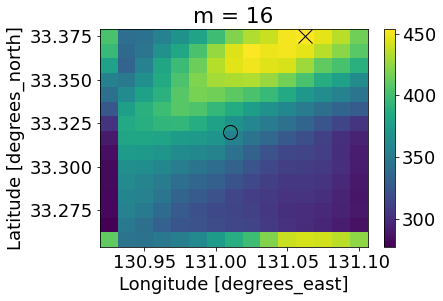

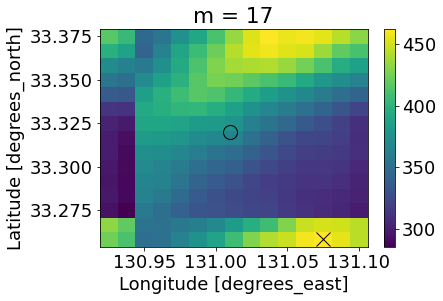

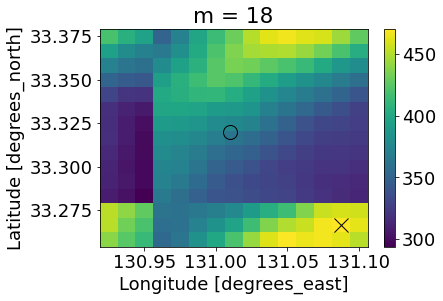

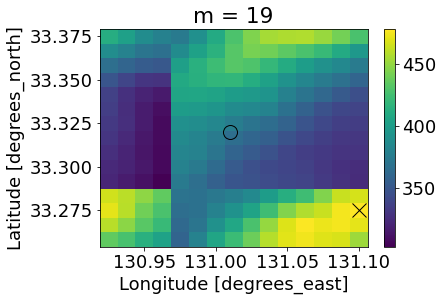

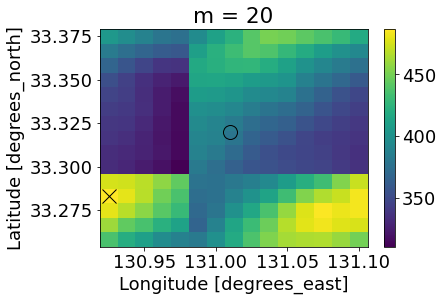

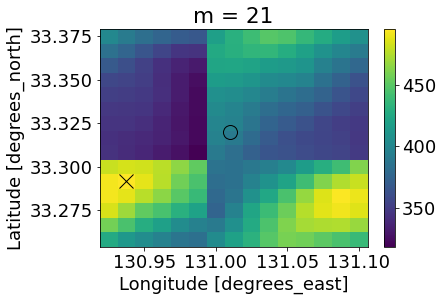

In [1015]:
def draw_ind(ind, lon1, lat1, lon_max4, lat_max4): 
    
    fs = 18
    plt.rcParams["font.size"]   = fs
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(1, 1, 1)
    # 土砂災害危険度指数の（時間）最大値を描く
    ind.plot()
    # 指定した地点（土壌雨量指数の下絵に対してクリックした地点）をoでプロット
    plt.plot(lon1, lat1, marker='o', color='black', markersize=14, fillstyle='none', mew=1) 
    # 土砂災害危険度指数が最大の地点をxでプロット
    plt.plot(lon_max4, lat_max4, marker='x', color='black', markersize=14, fillstyle='none', mew=1) 

ind4_e = calc_landslide_lisk_index(swi4_e, p1h4_e)

swi4_e_f = swi4_e.isel(TIME=slice(7,13)) # 予測部分の切り取り
p1h4_e_f = p1h4_e.isel(TIME=slice(7,13)) # 予測部分の切り取り
ind4_e_f = ind4_e.isel(TIME=slice(7,13)) # 予測部分の切り取り

ind4_e_f_tmax = ind4_e_f.max("TIME") # FT=1h~6h に対して時間最大をとる    

ind4_e_f_tmax
#ind4_e_f_tmax.plot(x="LON", y="LAT", col="m", col_wrap=7)

lon_max4_e = np.zeros(nmax)
lat_max4_e = np.zeros(nmax)

it_max = ind4_e.TIME.size
swi4_max_e = np.zeros([nmax, it_max])
p1h4_max_e = np.zeros([nmax, it_max])

for m in range(nmax): 
#for m in range(2): 

    # 土砂災害危険度指数の（時間）最大値が最大となる地点(x)の緯度経度を抽出
    lon_max4, lat_max4 = calc_maxloc(ind4_e_f_tmax[m])
    draw_ind(ind4_e_f_tmax[m], lon1, lat1, lon_max4, lat_max4) 

    swi4_max = swi4_e.isel(m=i).sel(LON=lon_max4, LAT=lat_max4, method="nearest") 
    p1h4_max = p1h4_e.isel(m=i).sel(LON=lon_max4, LAT=lat_max4, method="nearest") 

    lon_max4_e[m] = lon_max4
    lat_max4_e[m] = lat_max4
    swi4_max_e[m, :] = swi4_max
    p1h4_max_e[m, :] = p1h4_max
        
#lon_max4_e
#lat_max4_e
#swi4_max_e.shape
#p1h4_max_e.shape

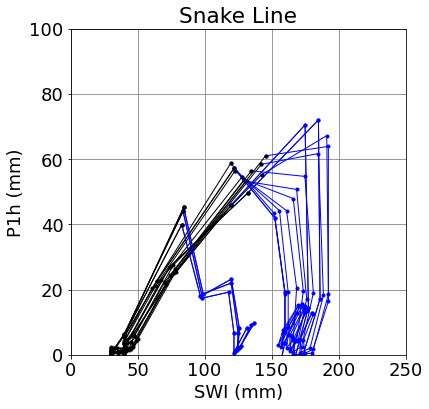

In [1016]:
# スネーク曲線の描画
swi5 = xr.DataArray(swi4_max_e, coords=[n_member, times], dims=['m', 'TIME'])
p1h5 = xr.DataArray(p1h4_max_e, coords=[n_member, times], dims=['m', 'TIME'])
draw_snake_line_ens(swi5, p1h5, nmax)

# 以降の max, medeia, mean を選ぶ作業は、(3)の場合と同様